In [ ]:
# 必要なライブラリーのインポート
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

# 統計モデル
import statsmodels.api as sm

# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [ ]:
# https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html
df = pd.read_csv('AirPassengers.csv')

# float型に変換
df['#Passengers'] = df['#Passengers'].astype('float64')
df = df.rename(columns={'#Passengers': 'Passengers'})

# datetime型にしてインデックスにする
df.Month = pd.to_datetime(df.Month)
df = df.set_index("Month")

# データの中身を確認
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


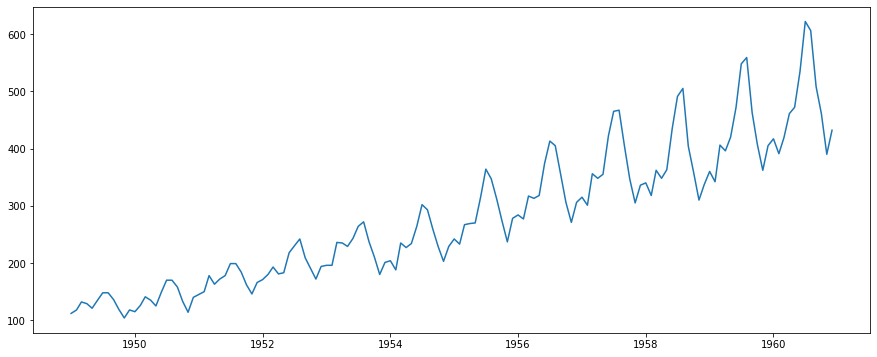

In [ ]:
plt.plot(df.Passengers)

In [ ]:
# 移動平均
df["3ma"]=df["Passengers"].rolling(3).mean().round(1)
df["5ma"]=df["Passengers"].rolling(5).mean().round(1)
df["7ma"]=df["Passengers"].rolling(7).mean().round(1)

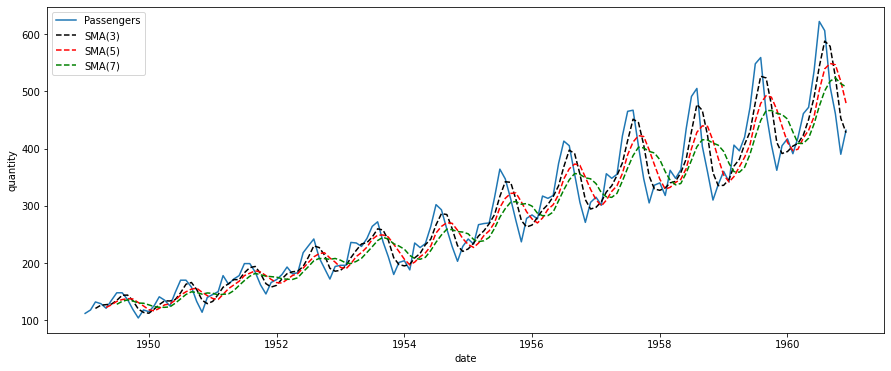

In [ ]:
# 可視化
plt.plot(df["Passengers"], label="Passengers")
plt.plot(df["3ma"], "k--", label="SMA(3)")
plt.plot(df["5ma"], "r--", label="SMA(5)")
plt.plot(df["7ma"], "g--", label="SMA(7)")
plt.xlabel("date")
plt.ylabel("quantity")
plt.legend()

plt.show()

In [ ]:
# 自己相関を求める
df_acf = sm.tsa.stattools.acf(df["Passengers"], nlags=30)
df_acf

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542,
       0.71376997, 0.6817336 , 0.66290439, 0.65561048, 0.67094833,
       0.70271992, 0.74324019, 0.76039504, 0.71266087, 0.64634228,
       0.58592342, 0.53795519, 0.49974753, 0.46873401, 0.44987066,
       0.4416288 , 0.45722376, 0.48248203, 0.51712699, 0.53218983,
       0.49397569, 0.43772134, 0.3876029 , 0.34802503, 0.31498388,
       0.28849682])

<Figure size 864x576 with 0 Axes>

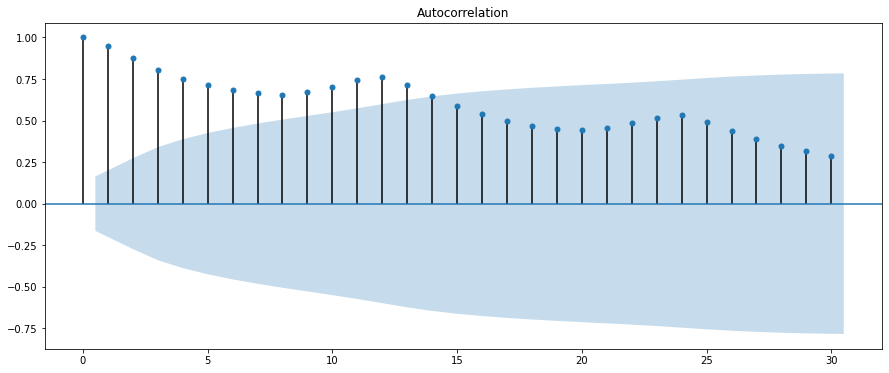

In [ ]:
#  自己相関のグラフ
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(df["Passengers"], lags=30)

In [ ]:
# 偏自己相関を求める
df_pacf = sm.tsa.stattools.pacf(df["Passengers"], nlags=30, method='ols')
df_pacf

array([ 1.        ,  0.95893198, -0.32983096,  0.2018249 ,  0.14500798,
        0.25848232, -0.02690283,  0.20433019,  0.15607896,  0.56860841,
        0.29256358,  0.8402143 ,  0.61268285, -0.66597616, -0.38463943,
        0.0787466 , -0.02663483, -0.05805221, -0.04350748,  0.27732556,
       -0.04046447,  0.13739883,  0.3859958 ,  0.24203808, -0.04912986,
       -0.19599778, -0.15443575,  0.04484465,  0.18371541, -0.0906113 ,
       -0.06202938])

<Figure size 864x576 with 0 Axes>

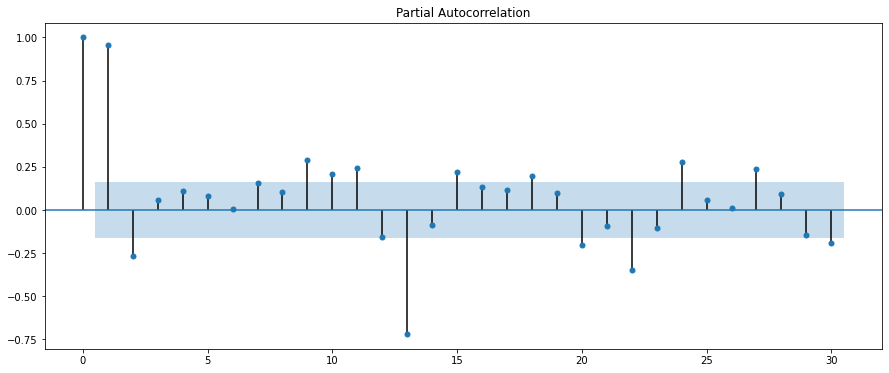

In [ ]:
# 偏自己相関を可視化する
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.tsa.plot_pacf(df["Passengers"], lags=30)

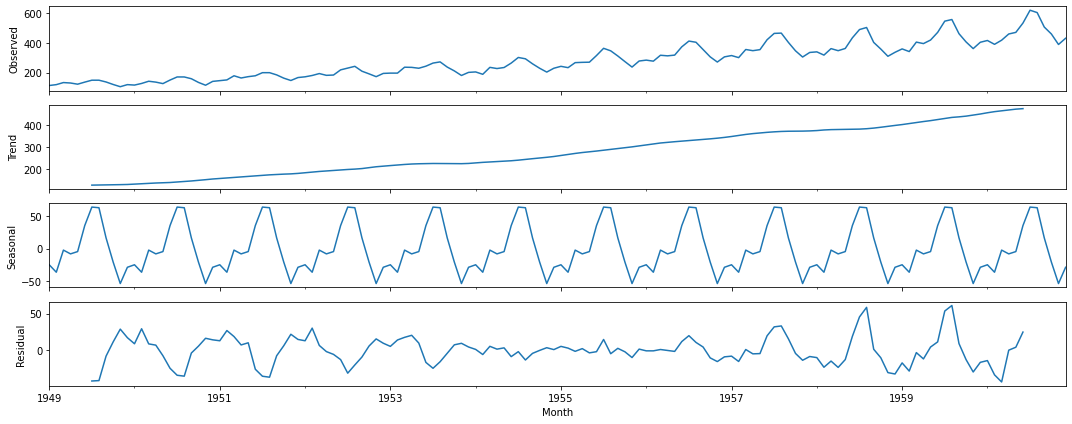

In [ ]:
res = sm.tsa.seasonal_decompose(df["Passengers"])
fig = res.plot()

In [ ]:
def invert(data, diff, prepro):
    """前処理に応じた逆変換をする

    Parameters
    ----------
    data (np.array or np.float) : 原系列のデータ
    diff (np.array or np.float) : 変換したデータ
    prepro (str) : 前処理の手法（'diff', 'pct', 'logdiff')

    """
    if prepro == 'diff':
      return data + diff
    elif prepro == 'pct':
      return data * diff + data
    elif prepro == 'logdiff':
      return np.exp(diff) * data
    else:
      print('{}は対応していない前処理です'.format(prepro))
      return None

In [ ]:
def invert_predict(data, pred, start, prepro, period, span=None):
    """前処理した系列の予測値を原系列に逆変換する

    Parameters
    ----------
    data (np.array) : 実測値
    pred (np.array) : 予測値
    start (int) : 逆変換して得る最初の期
    prepro (str) : 前処理手法（'diff', 'pct', 'logdiff')
    period (int) : 何期先まで予測したか
    xlim (turple) : 原系列グラフのx軸の描画範囲
    ylim (turple) : 原系列グラフのy軸の描画範囲

    """
    pred_inverted = np.empty_like(pred)

    if span == None:
      pred_inverted[0] = invert(data[start - 1], pred[0], prepro)
      for i in range(1, period):
        pred_inverted[i] = invert(pred_inverted[i - 1], pred[i], prepro)
    else:
      for i in range(span):
        pred_inverted[i, 0] = invert(data[start - period + i], pred[i, 0], prepro)
        for j in range(1, period):
          pred_inverted[i, j] = invert(pred_inverted[i, j-1], pred[i, j], prepro)
    
    return pred_inverted


In [ ]:
def plot_processed_series(data, pred, start, data_num, interval, prepro, axis):
    """前処理した系列の実測値及び予測値をグラフに書き出す

    Parameters
    ----------
    data (np.array) : 実測値
    pred (np.array) : 予測値
    start (int) : プロットの最初の期
    data_num (int) : 予測に使用したデータの数
    interval (int) : プロットする区間の長さ
    prepro (str) : 前処理手法（'diff', 'pct', 'logdiff')
    axis (matplotlib.axes.Axes) : 書き出したいグラフのAxesオブジェクト

    """
    if prepro == 'diff':
      target = data.diff().values
    elif prepro == 'pct':
      target = data.pct_change().values
    elif prepro == 'logdiff':
      target = (np.log(data) - np.log(data.shift(1))).values
    axis.plot(np.arange(start-data_num, start), target[start-data_num:start], marker='.')
    axis.plot(np.arange(start, start+interval), target[start:start+interval], c='green', label='Actual', marker='.')
    axis.plot(np.arange(start, start+interval), pred, c='r', label='Predict', marker='.')
    axis.set_ylabel('diff', fontsize=17)
    axis.legend()
    
    return None

In [ ]:
def plot_original_series(data, pred, start, interval, axis, xlim, ylim):
    '''逆変換した系列の実測値および予測値をグラフに書き出す.

    Parameters
    ----------
    data (np.array) : 実測値
    pred (np.array) : 予測値
    start (int) : プロットの最初の期
    interval (int) : プロットする区間の長さ
    axis (matplotlib.axes.Axes) : 書き出したいグラフのAxesオブジェクト
    xlim (turple) : 原系列グラフのx軸の描画範囲
    ylim (turple) : 原系列グラフのy軸の描画範囲

    '''
    axis.plot(np.arange(1, start+interval+1), data[:start+interval], c='green', label='Actual', marker='.')
    axis.plot(np.arange(start+1, start+interval+1), pred, c='r', label='Predict', marker='.')
    axis.set_xlim(xlim)
    axis.set_ylim(ylim)
    axis.set_ylabel('Passengers', fontsize=17)
    axis.legend()

    return None

In [ ]:
def plot_predict(data, pred, start, data_num, prepro, xlim=None, ylim=None):
    """AR(MA)モデルで予測したデータからグラフを描画する

    Parameters
    ----------
    data (np.array) : 実測値
    pred (np.array) : 予測値
    start (int) : プロットを始める期（ > data_num)
    data_num (int) : データをいくつ利用したか
    prepro (str) : データの前処理方法（'diff', 'pct', 'logdiff')
    xlim (turple) : 原系列グラフのx軸の描画範囲
    ylim (turple) : 原系列グラフのy軸の描画範囲

    """
    period = len(pred) #何期先までの予測をしたか

    # 逆変換して原系列の予測を用意
    pred_inverted = invert_predict(data, pred, start, prepro, period)

    # 処理した系列、原系列について実測値と予測値の比較
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    plt.rcParams["font.size"] = 12
    plt.subplots_adjust(wspace = 0.3)
    plot_processed_series(data, pred, start, data_num, period, prepro, axes[0])
    plot_original_series(data, pred_inverted, start, period, axes[1], xlim, ylim)

    plt.show()
    
    return None

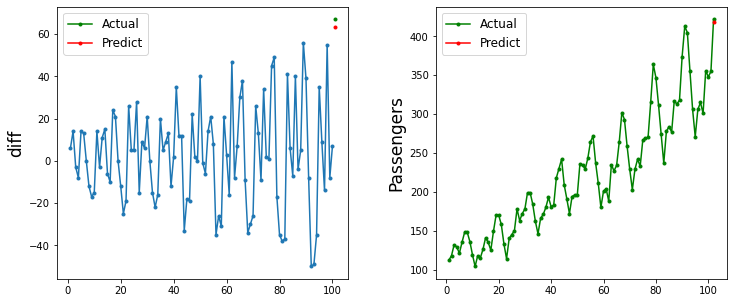

In [ ]:
target = df["Passengers"].diff().values

start = 101
period = 1
data_num = 100

pred = sm.tsa.AR(target[start-data_num:start]).fit(maxlag=12).predict(start=data_num, end=data_num+period-1)
plot_predict(df["Passengers"], pred, start, data_num, 'diff')

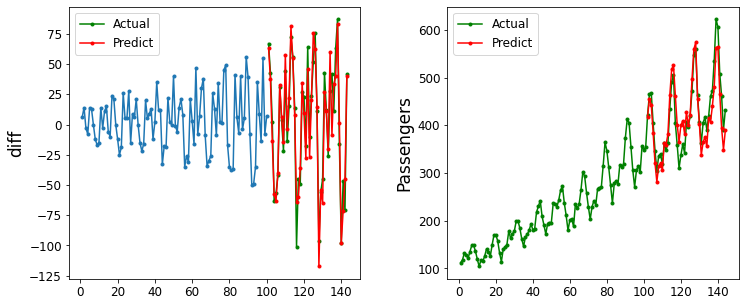

In [ ]:
start = 101
period = 1

pred_seq = np.arange(start+period-1, len(df))
pred = np.empty((len(pred_seq), period), dtype=float)

for i, j in enumerate(pred_seq):
  pred[i] = sm.tsa.AR(target[j-period+1-data_num:j-period+1]).fit(maxlag=12).predict(start=data_num, end=data_num+period-1)
plot_predict(df["Passengers"], pred, start, data_num, 'diff')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: Converge

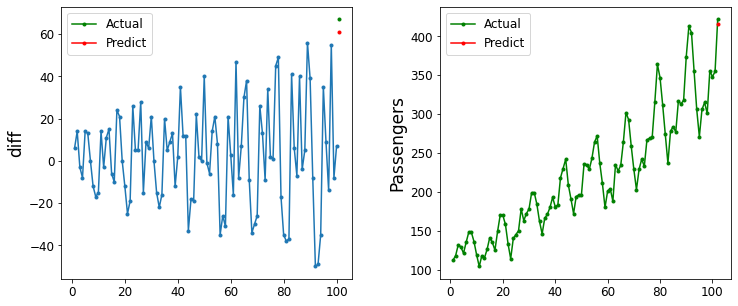

In [ ]:
target = df["Passengers"].diff().values

start = 101
period = 1
data_num = 100

pred = sm.tsa.ARMA(target[start-data_num:start], order=(9, 3)).fit().predict(start=data_num, end=data_num+period-1)
plot_predict(df["Passengers"], pred, start, data_num, 'diff')

In [ ]:
start = 101
period = 1

pred_seq = np.arange(start+period-1, len(df))
pred = np.empty((len(pred_seq), period), dtype=float)

for i, j in enumerate(pred_seq):
  pred[i] = sm.tsa.ARMA(target[j-period+1-data_num:j-period+1], order=(2, 2)).fit().predict(start=data_num, end=data_num+period-1)
plot_predict(df["Passengers"], pred, start, data_num, 'diff')

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


LinAlgError: ignored